# Inicio

In [13]:
# Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import os

In [14]:
# Cargar datos
data_dir = r"C:\Users\Macarena Madrid\Desktop\MT\Data"

ppi = pd.read_csv(os.path.join(data_dir, "1_PPI-network_Alzheimer_Disease_no-opentarget-filter.csv"))
targets = pd.read_excel(os.path.join(data_dir, "3_Targets-score_Alzheimer_Disease_no-opentarget-filter.xlsx"))
topo = pd.read_csv(os.path.join(data_dir, "topology_158_up_down_normalized_splitPCA.csv"))
enrichment = pd.read_excel(os.path.join(data_dir, "enrichment2.xlsx"), sheet_name=None)  # Todas las hojas

c:\Users\Macarena Madrid\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\Macarena Madrid\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
# Verificación de valores nulos
print("Valores nulos en PPI:", ppi.isnull().sum().sum())
print("Valores nulos en Targets:", targets.isnull().sum().sum())
print("Valores nulos en Topology:", topo.isnull().sum().sum())
print("Valores nulos en Enrichment:", {sheet: df.isnull().sum().sum() for sheet, df in enrichment.items()})
# Verificación de duplicados
print("Duplicados en PPI:", ppi.duplicated().sum())
print("Duplicados en Targets:", targets.duplicated().sum())
print("Duplicados en Topology:", topo.duplicated().sum())
print("Duplicados en Enrichment:", {sheet: df.duplicated().sum() for sheet, df in enrichment.items()})
# Verificación de tipos de datos
print("Tipos de datos en PPI:\n", ppi.dtypes)
print("Tipos de datos en Targets:\n", targets.dtypes)
print("Tipos de datos en Topology:\n", topo.dtypes)
print("Tipos de datos en Enrichment:")
for sheet, df in enrichment.items():
    print(f"{sheet}:\n", df.dtypes)
# Verificación de valores únicos
print("Valores únicos en PPI:", ppi.nunique())
print("Valores únicos en Targets:", targets.nunique())
print("Valores únicos en Topology:", topo.nunique())
print("Valores únicos en Enrichment:")
for sheet, df in enrichment.items():
    print(f"{sheet}:\n", df.nunique())

Valores nulos en PPI: 0
Valores nulos en Targets: 5486
Valores nulos en Topology: 0
Valores nulos en Enrichment: {'Biological process': 0, 'Molecular function': 0, 'Cellular component': 0}
Duplicados en PPI: 0
Duplicados en Targets: 0
Duplicados en Topology: 0
Duplicados en Enrichment: {'Biological process': 0, 'Molecular function': 0, 'Cellular component': 0}
Tipos de datos en PPI:
 Prot_A                object
Prot_B                object
Interaction_score    float64
Disease               object
dtype: object
Tipos de datos en Targets:
 Target_name                       object
Complex_participants              object
Node_id                           object
Uniprot_id                        object
Target_type                       object
Target_group                      object
Source_db                         object
Target_group_score               float64
Target_group_score_normalized    float64
Conectivity_Score                float64
Disease                           object
dtyp

# Información general sobre los datos

In [20]:
# Conteo de interacciones en la red PPI
num_interacciones = len(ppi)
proteinas_unicas = pd.unique(ppi[['Prot_A', 'Prot_B']].values.ravel('K'))
num_proteinas = len(proteinas_unicas)

print(f"Número de interacciones en la red PPI: {num_interacciones}")
print(f"Número de proteínas únicas en la red PPI: {num_proteinas}")

# Conteo de targets en el DataFrame de targets
num_targets = targets['Node_id'].nunique()
print(f"Número de targets en el DataFrame de targets: {num_targets}")

# Conteo de proteínas en el DataFrame de topología
num_proteinas_topo = topo['Node_id'].nunique()
print(f"Número de proteínas en el DataFrame de topología: {num_proteinas_topo}")



Número de interacciones en la red PPI: 426139
Número de proteínas únicas en la red PPI: 5411
Número de targets en el DataFrame de targets: 5411
Número de proteínas en el DataFrame de topología: 158



Distribución de grupos T (combinaciones):


,Grupo Target,Cantidad
0,"T3, T4",1
1,"T1, T2, T3, T4",7
2,"T1, T2",9
3,T3,15
4,"T1, T2, T3",22
5,"T2, T3, T4",29
6,"T2, T3",198
7,"T2, T4",198
8,T2,1090
9,T4,3842


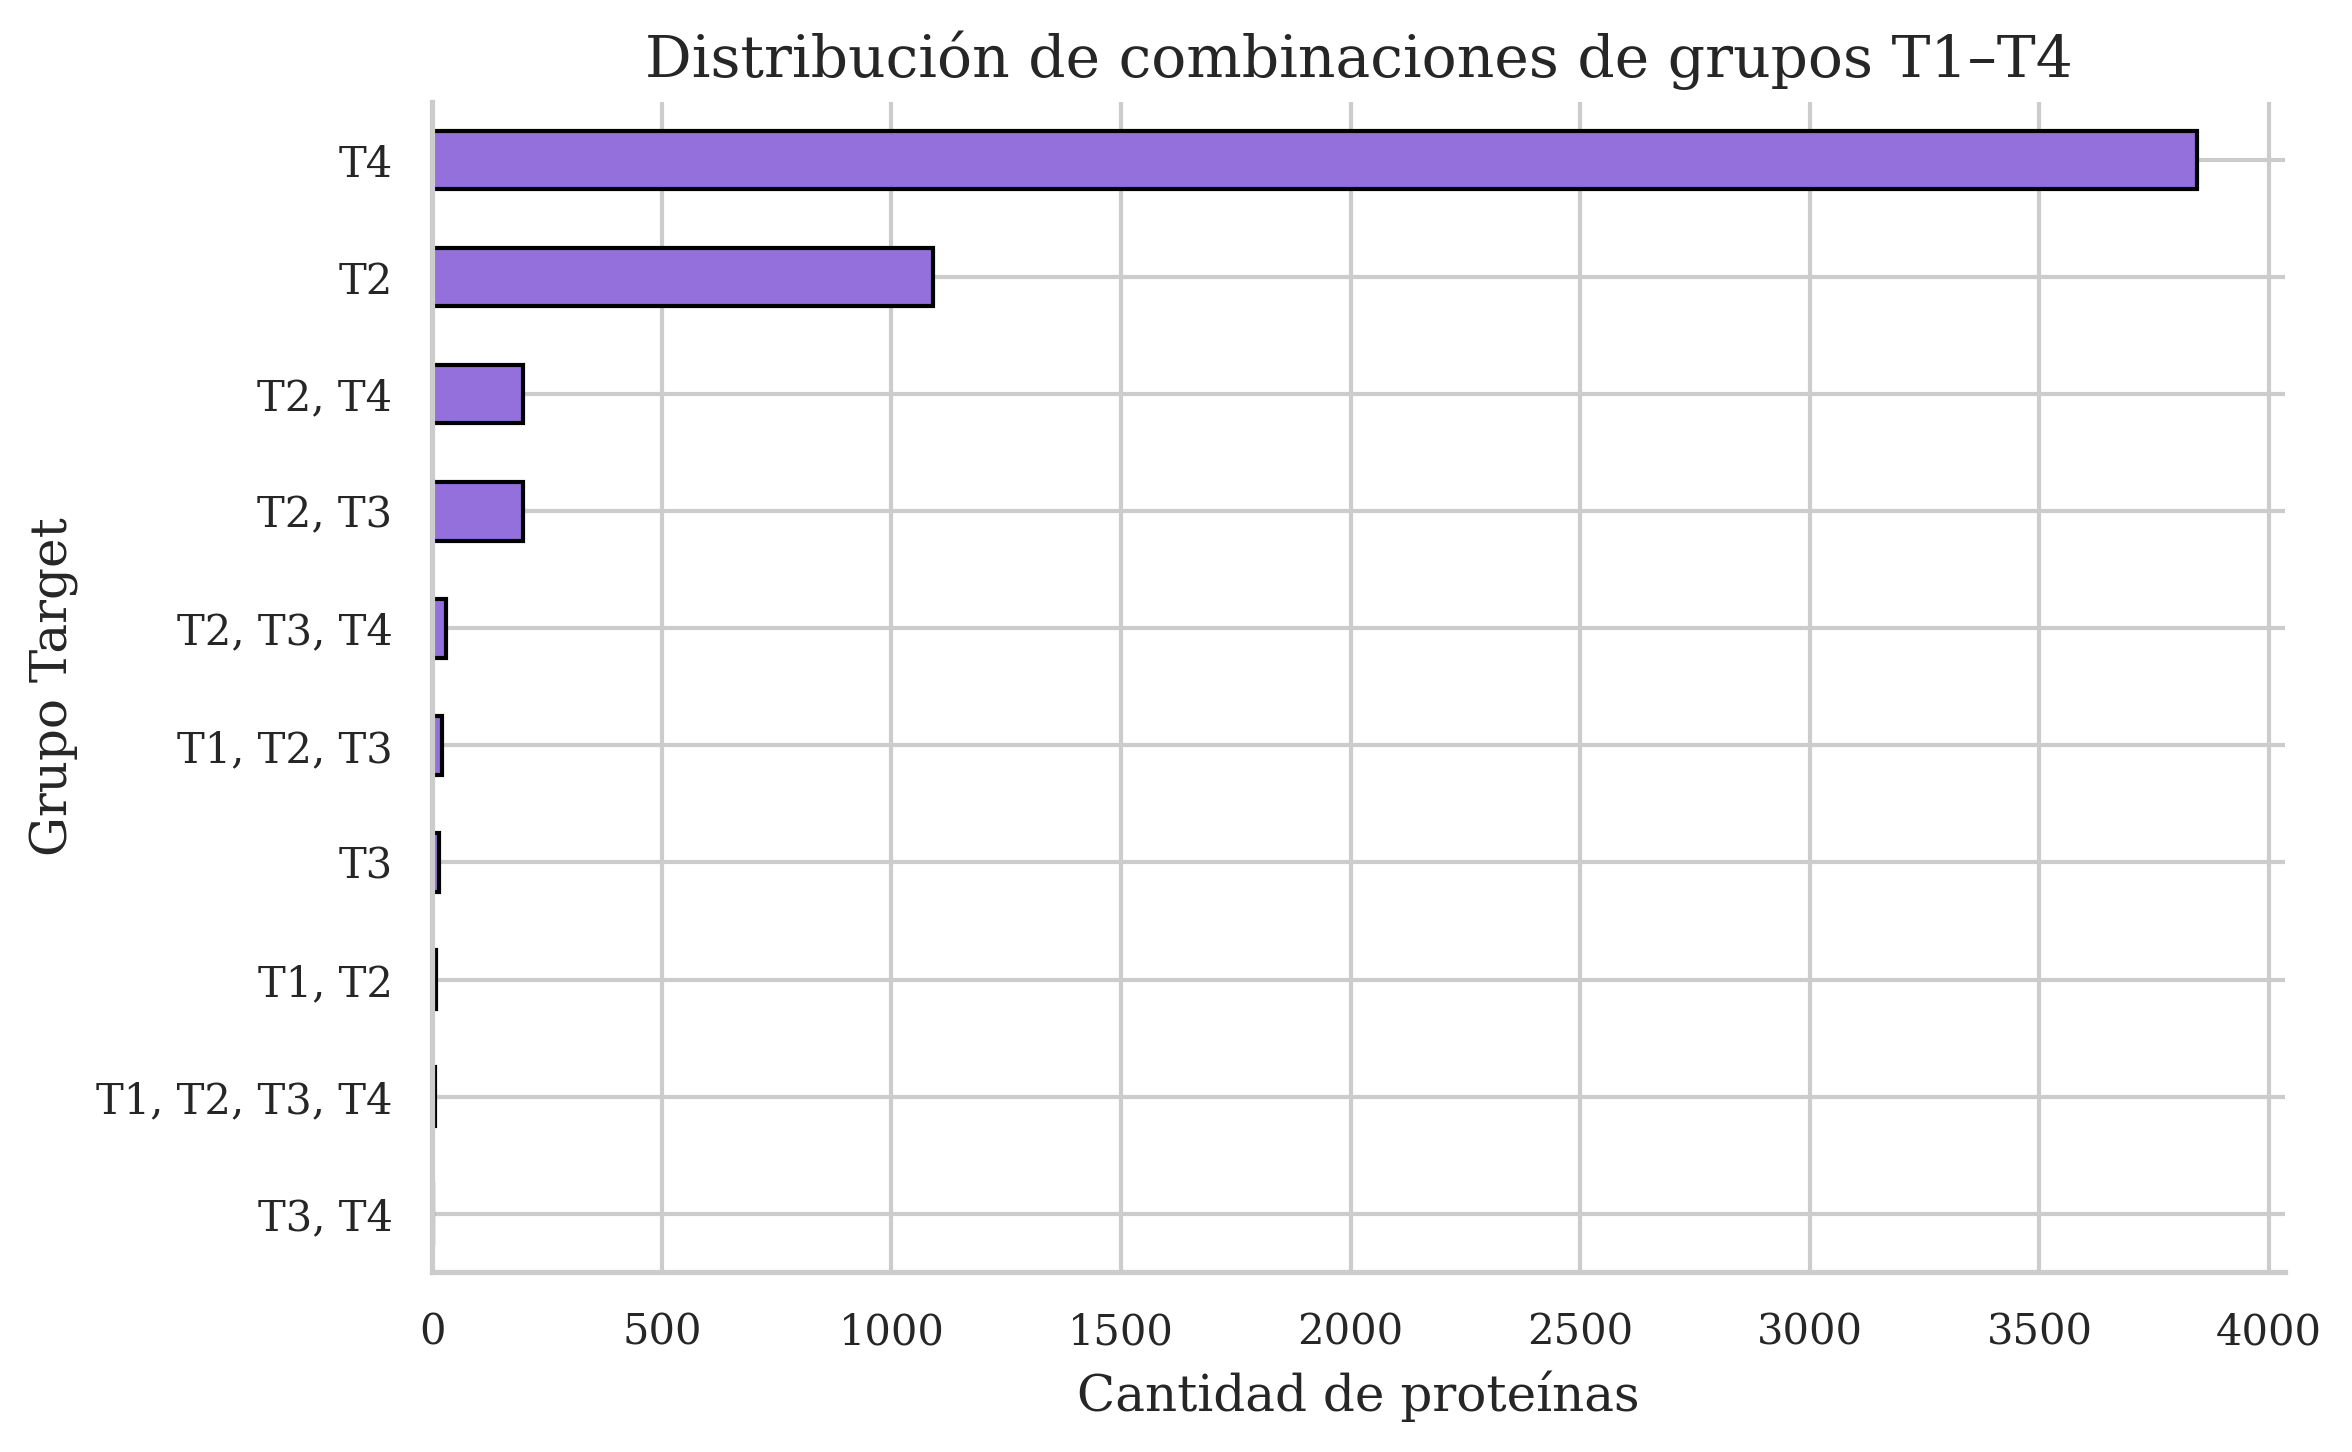

In [30]:
# === Conteo por grupos de T1–T4 (y combinaciones) ===
print("\nDistribución de grupos T (combinaciones):")
group_counts = targets['Target_group'].value_counts().sort_values()

# Mostrar como tabla
group_df = pd.DataFrame(group_counts).reset_index()
group_df.columns = ["Grupo Target", "Cantidad"]
display(group_df)

# === Estilo académico ===
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 300
})

# === Gráfico horizontal académico ===
fig, ax = plt.subplots(figsize=(8,5))
group_counts.plot.barh(
    ax=ax,
    color="mediumpurple",
    edgecolor="black"
)

ax.set_title("Distribución de combinaciones de grupos T1–T4")
ax.set_xlabel("Cantidad de proteínas")
ax.set_ylabel("Grupo Target")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("figura_combinaciones_T1_T4.pdf")  # Exportar en alta calidad
plt.show()



Distribución de etiquetas T1–T4:


,Cantidad
T1,38
T2,1553
T3,272
T4,4077


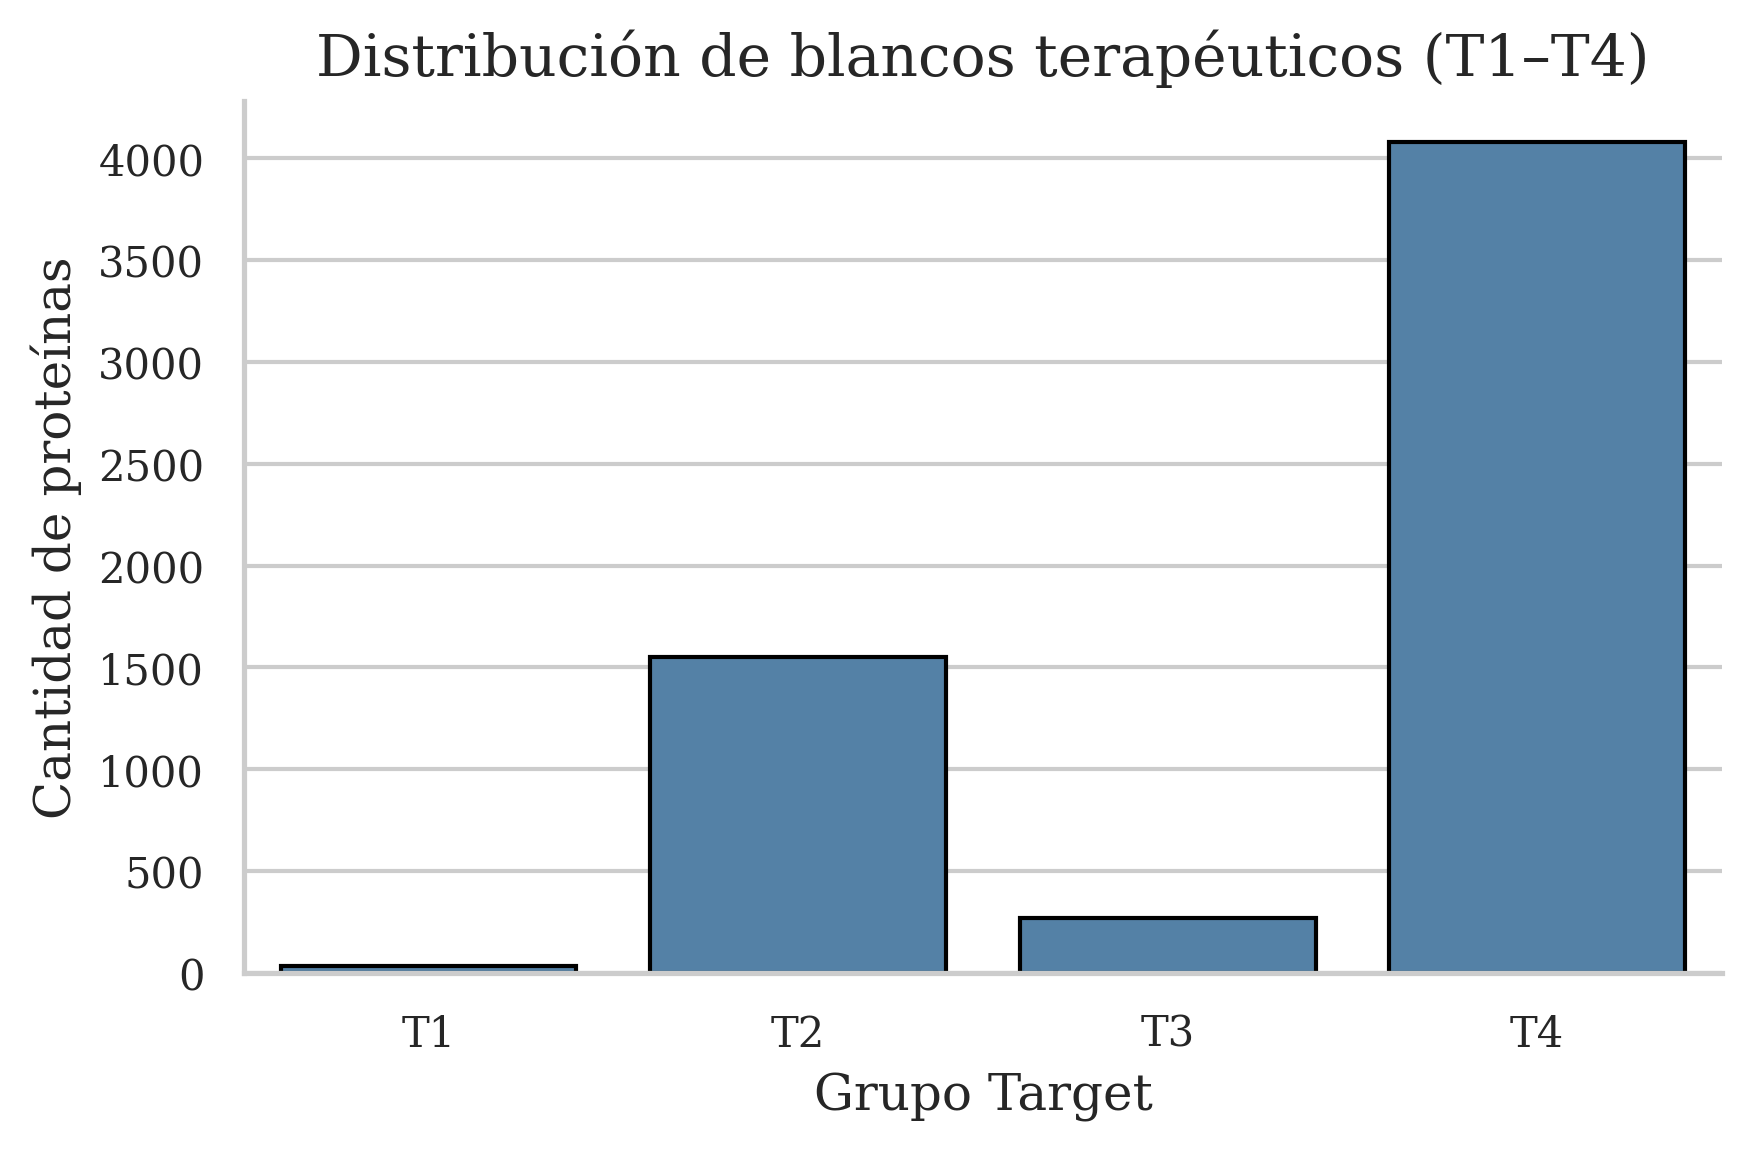

In [29]:
from collections import Counter 
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# === Preprocesamiento ===
targets["Target_group_list"] = targets["Target_group"].str.split(", ")
all_labels = list(itertools.chain.from_iterable(targets["Target_group_list"]))
label_counts = Counter(all_labels)

# Mostrar en tabla
print("Distribución de etiquetas T1–T4:")
label_df = pd.DataFrame.from_dict(label_counts, orient='index', columns=["Cantidad"]).sort_index()
display(label_df)

# === Estilo académico ===
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 300
})

# === Gráfico académico ===
plt.figure(figsize=(6,4))
sns.barplot(x=label_df.index, y=label_df["Cantidad"], color="steelblue", edgecolor="black")

plt.title("Distribución de blancos terapéuticos (T1–T4)")
plt.ylabel("Cantidad de proteínas")
plt.xlabel("Grupo Target")
sns.despine()  # Elimina bordes innecesarios (superior y derecho)
plt.tight_layout()
plt.savefig("figura_t1_t4.pdf")  # Guarda como PDF (alta calidad)
plt.show()


In [58]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# PDF de salida
pdf_output = "wordclouds_GO_por_frase_completa.pdf"

with PdfPages(pdf_output) as pdf:
    for ontology, df in enrichment.items():
        for label in ["T1", "T2", "T3", "T4"]:
            plt.figure(figsize=(6, 4))
            
            # Limpiar los nombres de términos (remover el GO ID)
            terms = df["Term Name"].str.replace(r"\s*\(GO:\d+\)", "", regex=True)

            # ❗ En lugar de unir todo como texto suelto, convertimos cada frase en una palabra única
            # Esto evita que "regulation", "positive" o "activity" actúen por separado
            frequencies = terms.value_counts().to_dict()

            wordcloud = WordCloud(
                width=800,
                height=400,
                background_color='white'
            ).generate_from_frequencies(frequencies)

            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.title(f"Wordcloud - {ontology} - {label}")
            plt.tight_layout()
            pdf.savefig()
            plt.close()

print("✅ WordClouds generados usando frases completas como tokens.")




✅ WordClouds generados usando frases completas como tokens.


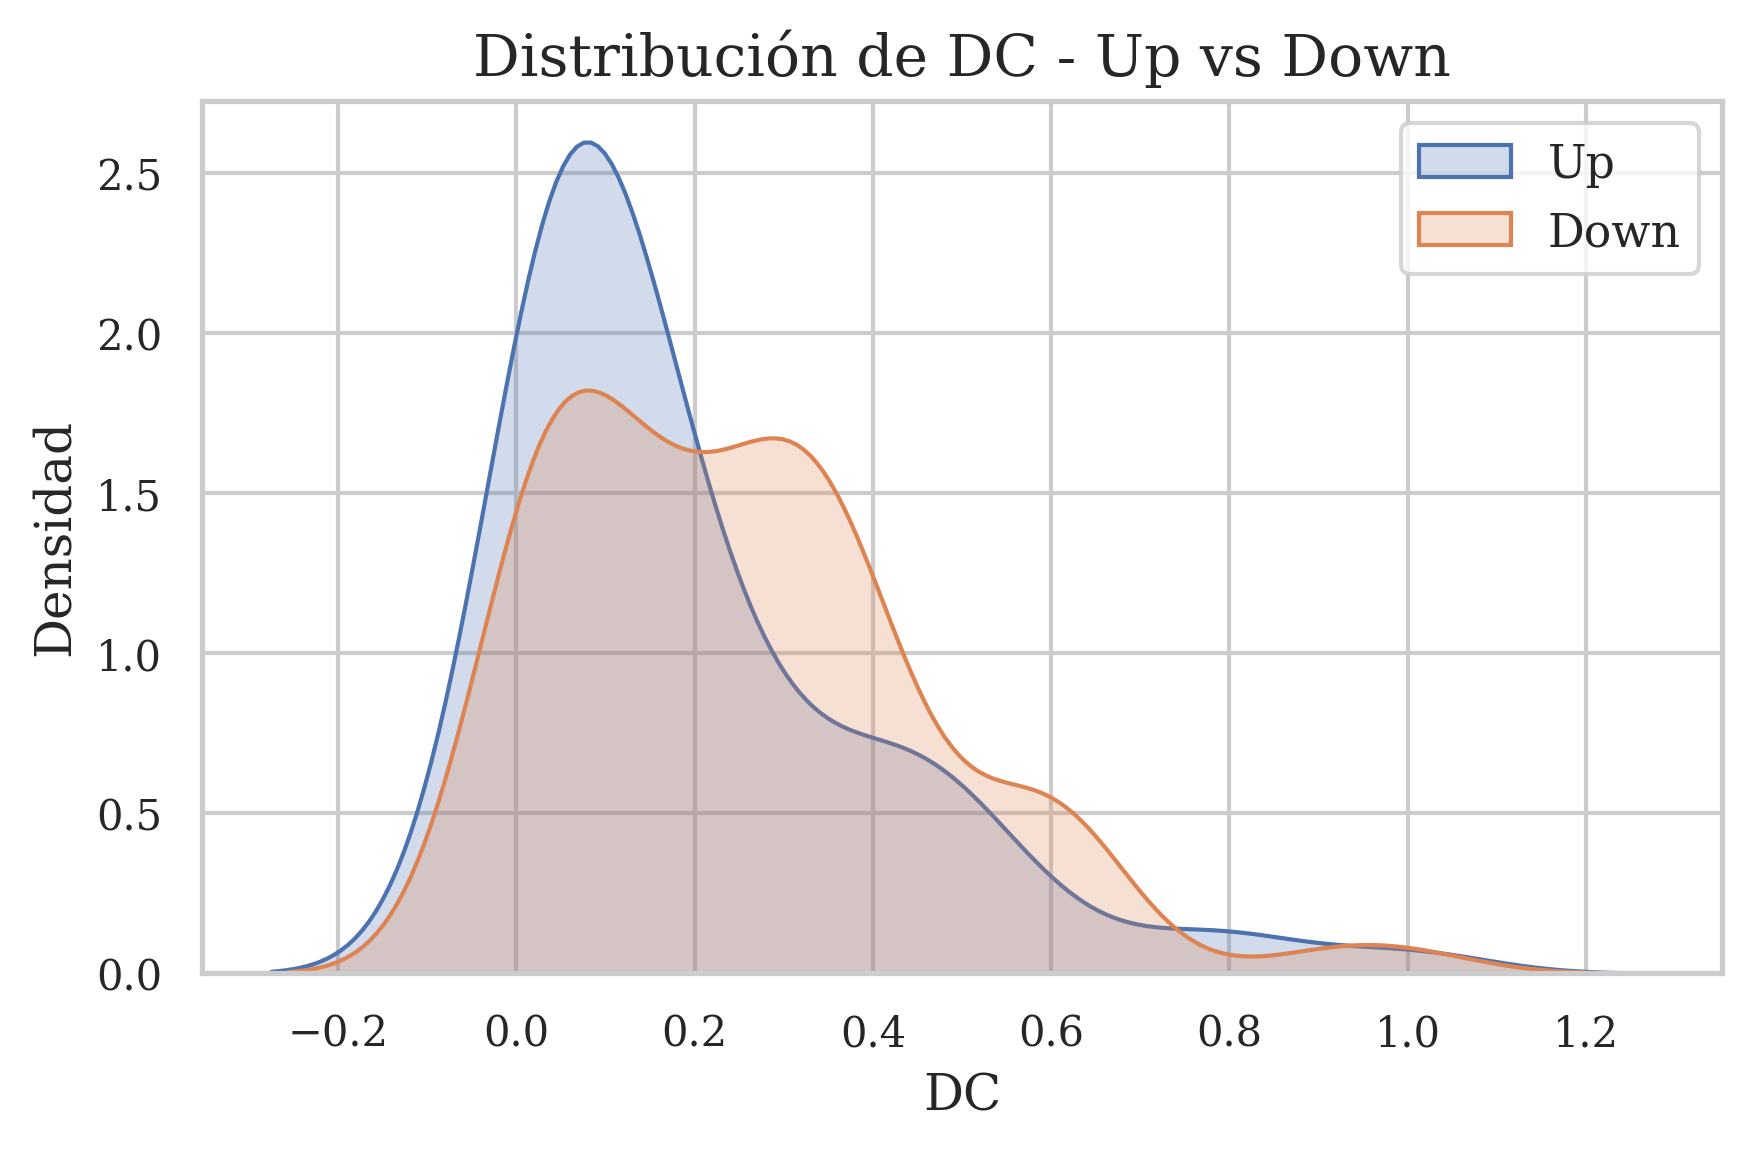

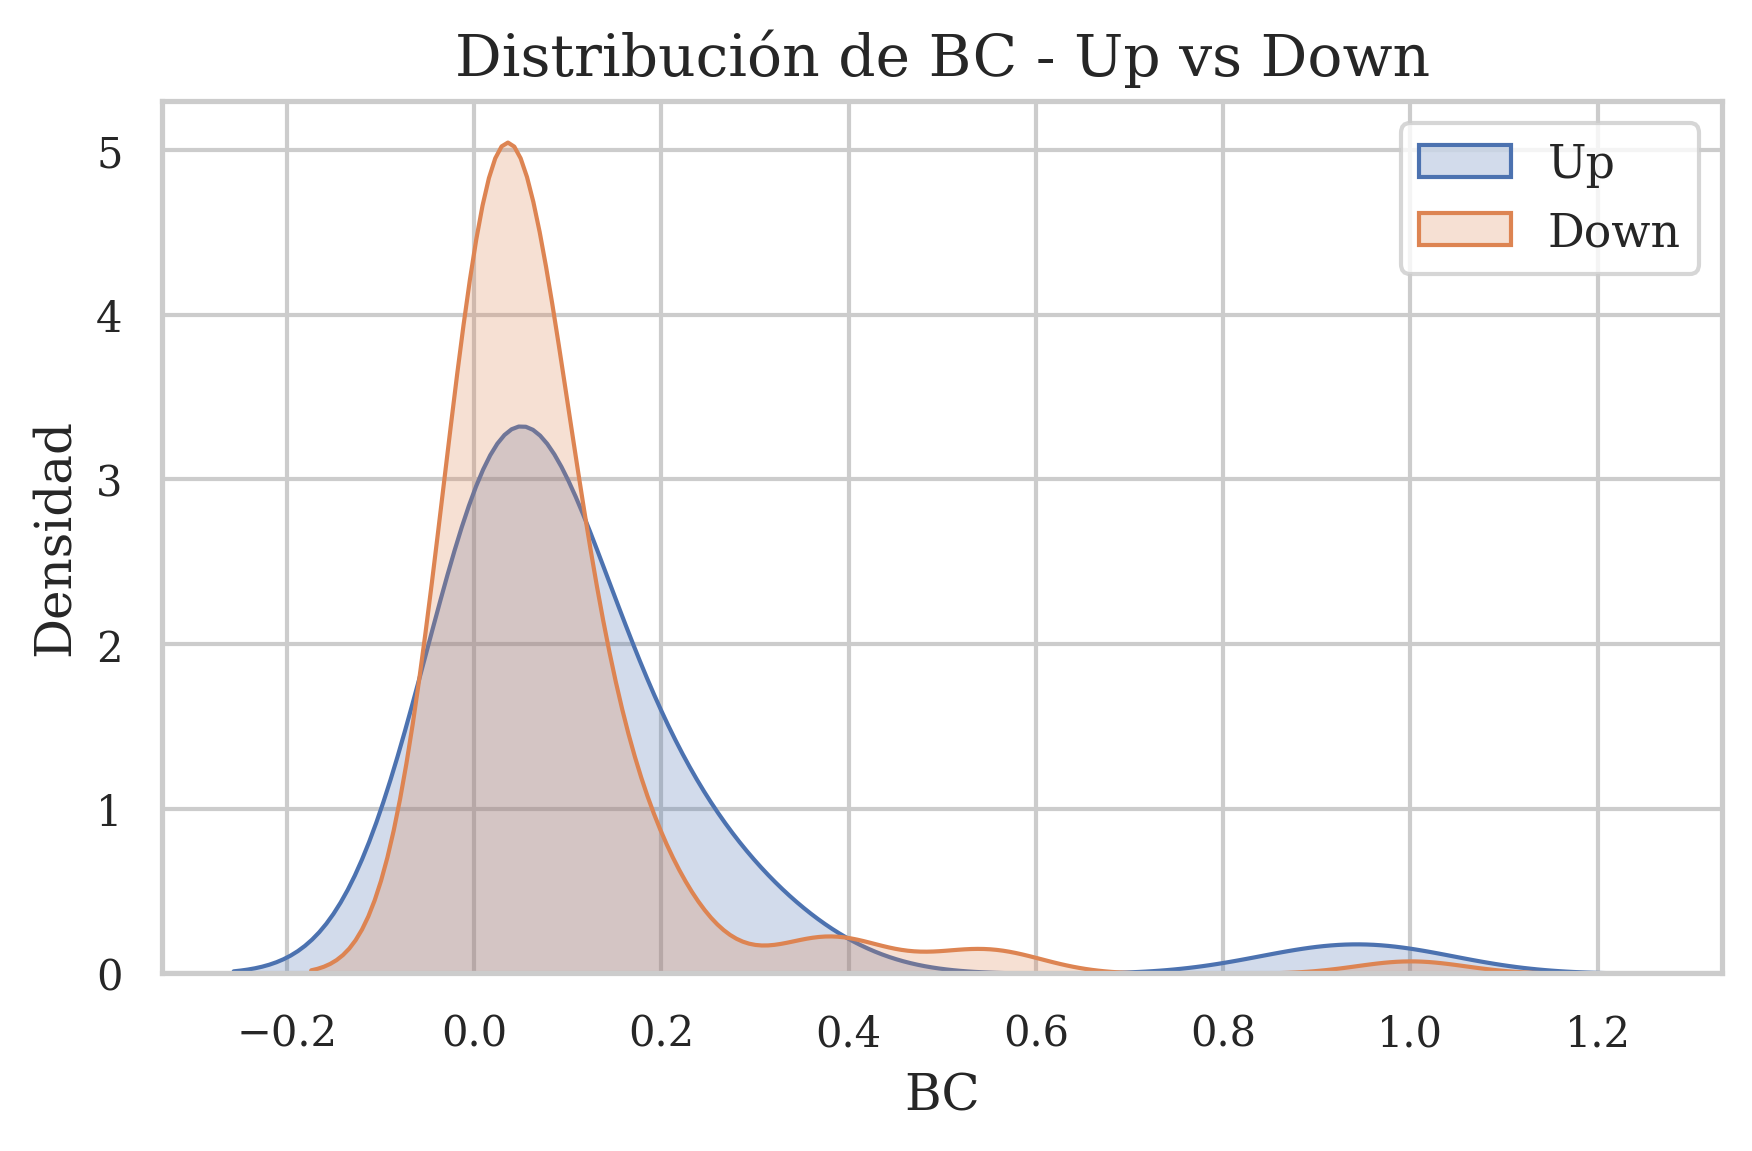

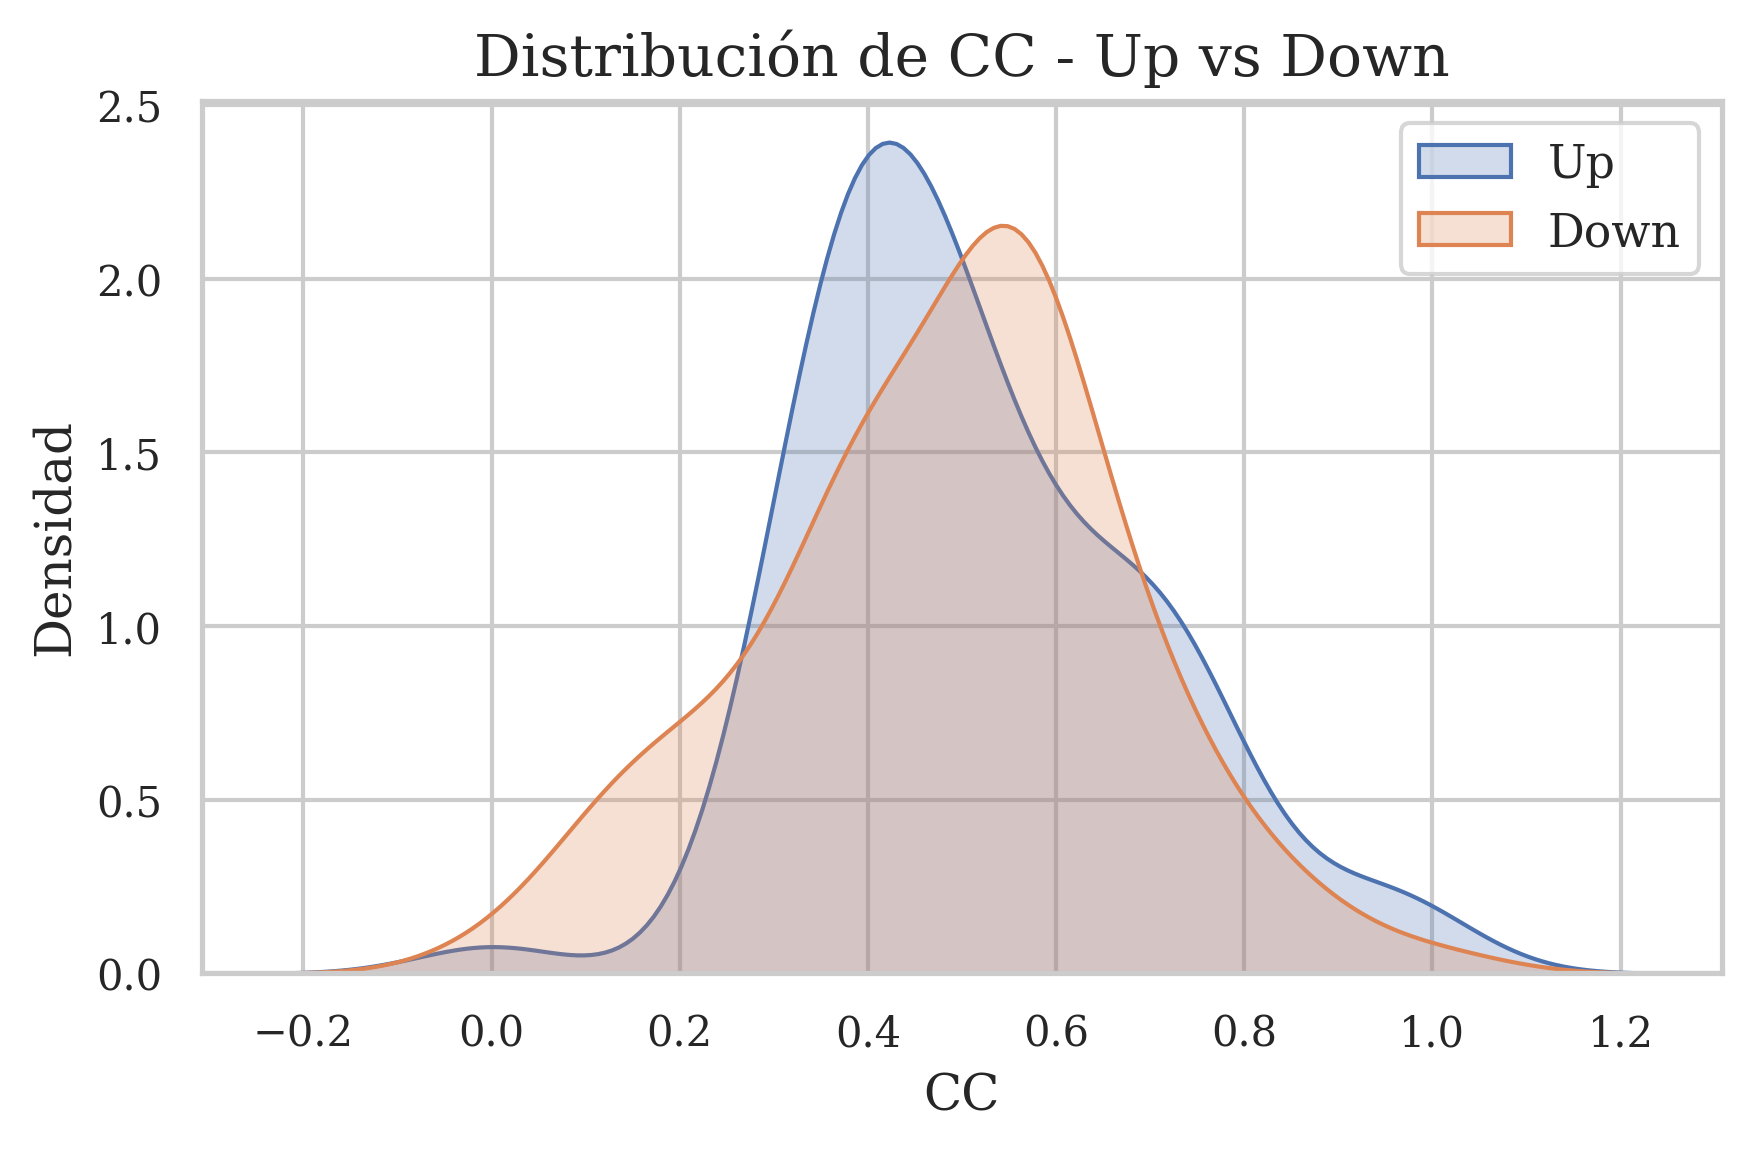

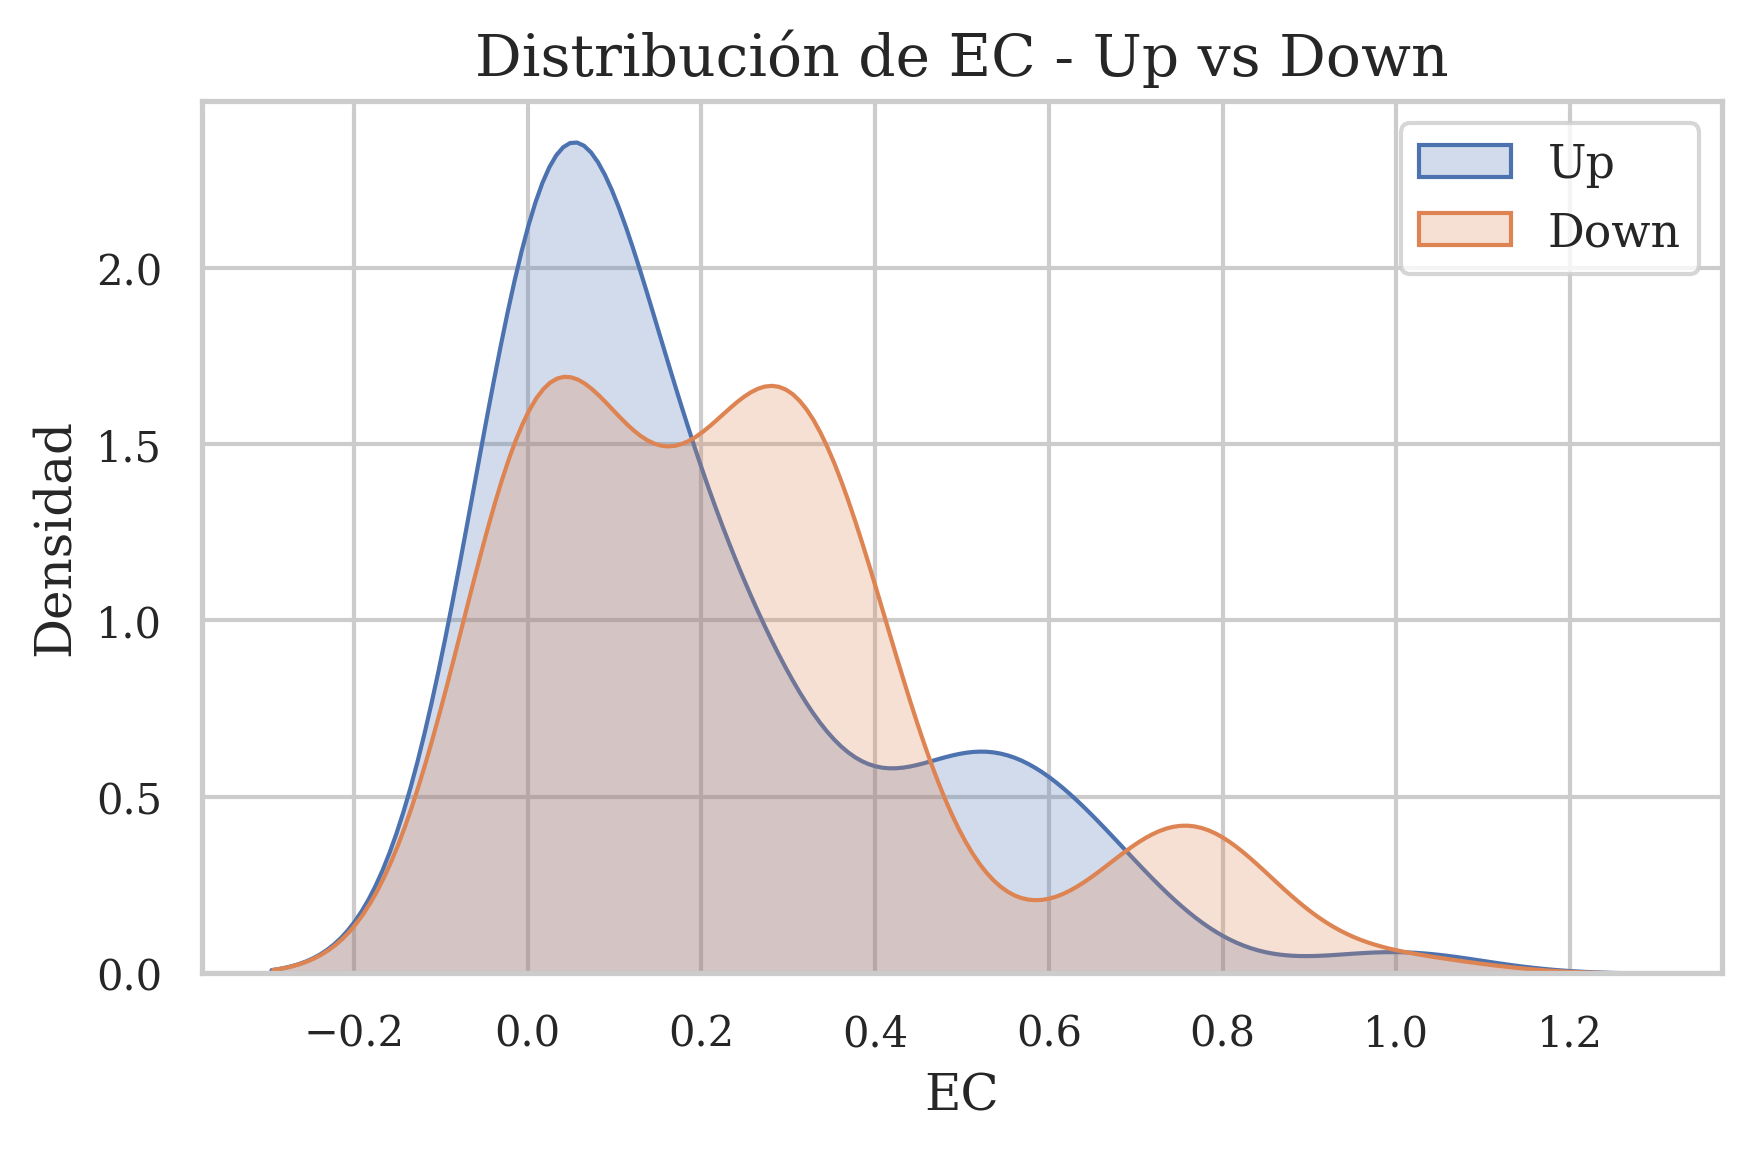

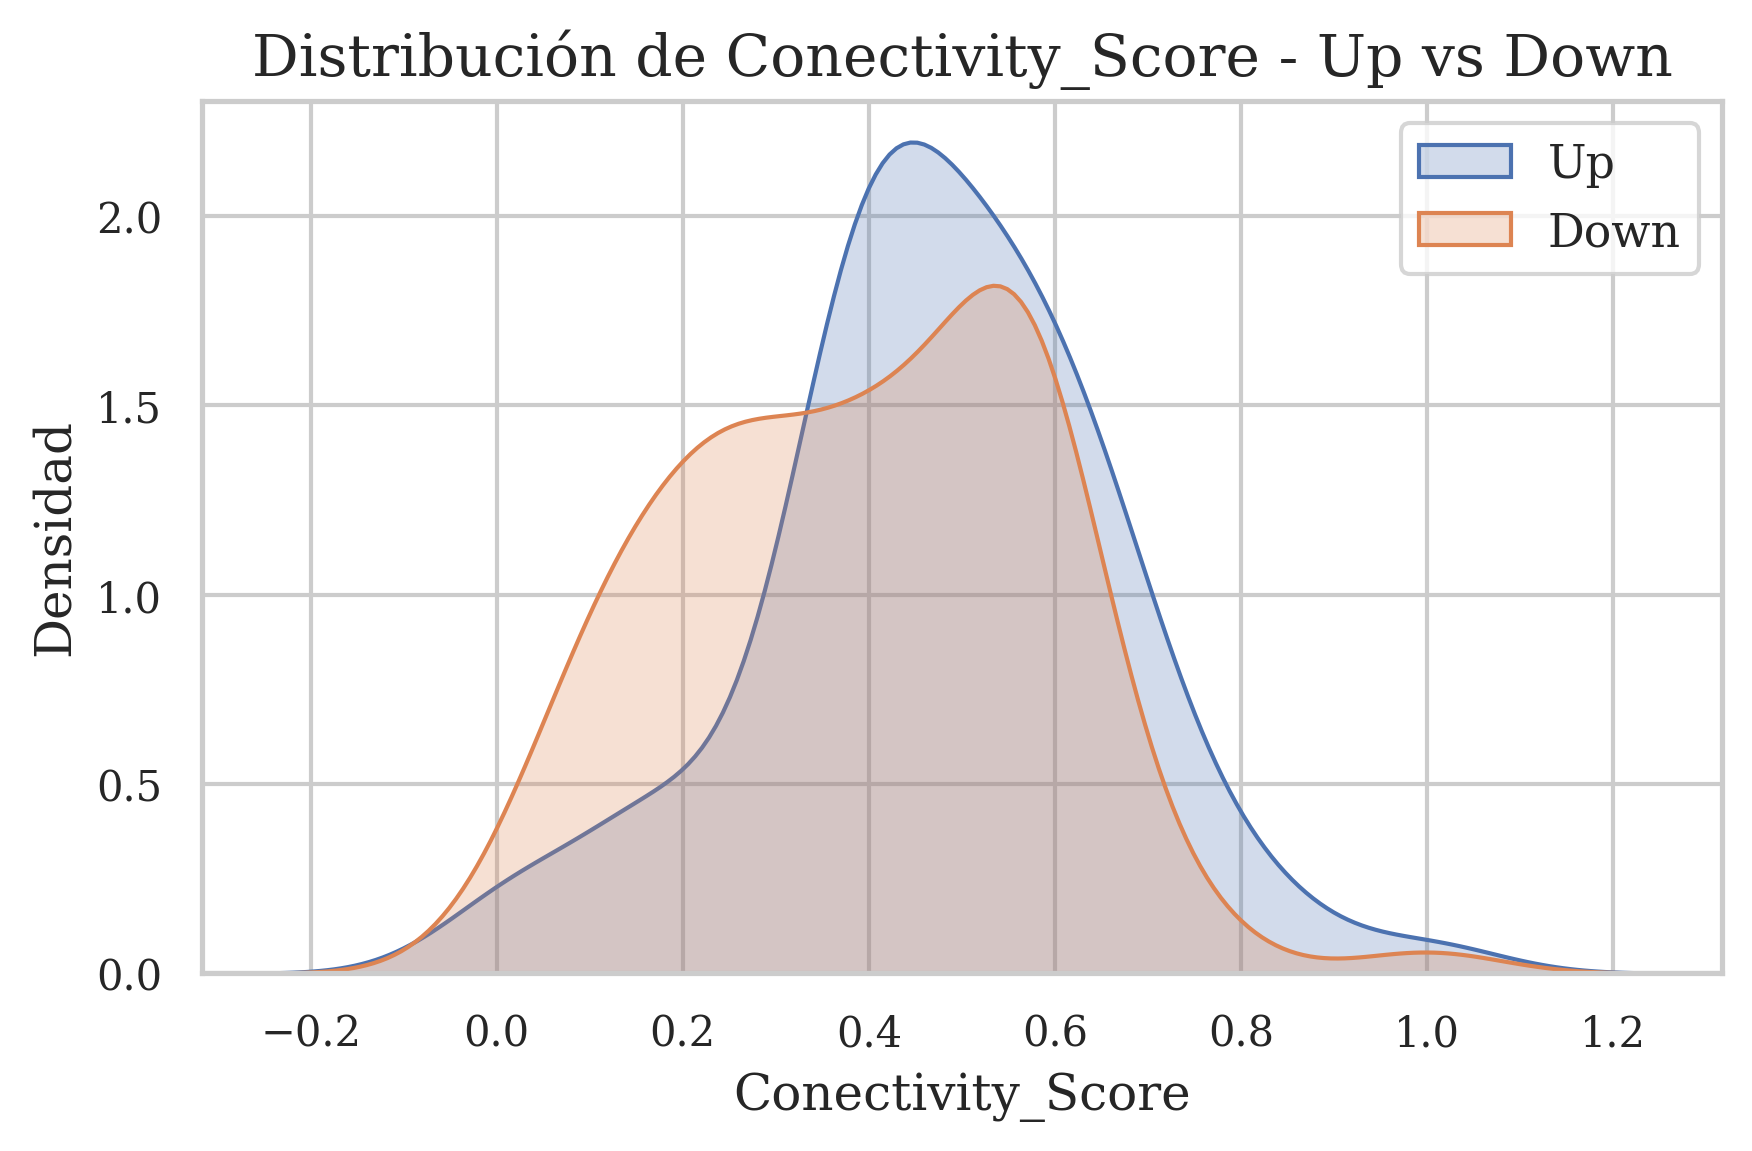

In [32]:
# Filtrado por proteínas Up y Down

up = topo[topo["prediction"] == "Up"]
down = topo[topo["prediction"] == "Down"]

# Gráficos comparativos por métrica topológica
for metric in ["DC", "BC", "CC", "EC", "Conectivity_Score"]:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=up, x=metric, label="Up", fill=True)
    sns.kdeplot(data=down, x=metric, label="Down", fill=True)
    plt.title(f"Distribución de {metric} - Up vs Down")
    plt.xlabel(metric)
    plt.ylabel("Densidad")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Revisión de datos topológicos

In [5]:

# Renombrar columna 'Node_id' a 'Protein' para hacer merge
topo = topo.rename(columns={"Node_id": "Protein"})
targets = targets.rename(columns={"Node_id": "Protein"})

# Hacer merge para ver qué Target_group tiene cada proteína del archivo topológico
topo_with_group = pd.merge(topo, targets[["Protein", "Target_group"]], on="Protein", how="left")

# Mostrar conteo por grupo
print("Distribución de Target_group entre proteínas topológicas:")
print(topo_with_group["Target_group"].value_counts(dropna=False))

# Mostrar vista previa
topo_with_group.head()


Distribución de Target_group entre proteínas topológicas:
Target_group
T4     157
NaN      1
Name: count, dtype: int64


,Protein,prediction,DC,BC,CC,EC,CEN,ECC,RAD,Conectivity_Score,Target_group
0,AGT,Up,0.749640,0.881329,0.922370,0.619335,0.094793,1.0,0.956340,0.703706,T4
1,APOE,Up,0.817266,0.943827,0.946559,0.655622,0.064516,1.0,0.970285,0.680186,T4
2,ALDH7A1,Up,0.274820,0.198363,0.627651,0.289315,0.400113,1.0,0.756549,0.580241,T4
3,GLUD1,Up,0.205755,0.141130,0.590557,0.068793,0.458970,1.0,0.726704,0.408576,T4
4,EPHX1,Up,0.109353,0.054785,0.352921,0.026284,0.887097,0.4,0.501368,0.700345,T4


In [8]:
# CONTEO UP / DOWN 
prediction_counts = topo_with_group["prediction"].value_counts()
print("\nDistribución de predicción (Up / Down):")
print(prediction_counts)

# ESTADÍSTICAS DE CONECTIVIDAD CON T4 
conectivity_stats = topo_with_group["Conectivity_Score"].describe()
print("\nEstadísticas de Conectivity_Score:")
print(conectivity_stats)

# PROMEDIO DE CONECTIVIDAD POR GRUPO
group_connectivity_mean = topo_with_group.groupby("Target_group")["Conectivity_Score"].mean()
print("\nPromedio de Conectivity_Score por Target_group:")
print(group_connectivity_mean)

# PREDICCIÓN UP / DOWN DENTRO DEL GRUPO T4
t4_updown = topo_with_group[topo_with_group["Target_group"] == "T4"]["prediction"].value_counts()
print("\nDistribución de Up / Down dentro del grupo T4:")
print(t4_updown)

#MOSTRAR VISTA PREVIA DE LOS DATOS COMBINADOS
print("\nVista previa de los datos combinados:")
display(topo_with_group.head())


Distribución de predicción (Up / Down):
prediction
Down    91
Up      67
Name: count, dtype: int64

Estadísticas de Conectivity_Score:
count    158.000000
mean       0.426127
std        0.195098
min        0.000000
25%        0.291396
50%        0.424866
75%        0.565477
max        1.000000
Name: Conectivity_Score, dtype: float64

Promedio de Conectivity_Score por Target_group:
Target_group
T4    0.425364
Name: Conectivity_Score, dtype: float64

Distribución de Up / Down dentro del grupo T4:
prediction
Down    90
Up      67
Name: count, dtype: int64

Vista previa de los datos combinados:


,Protein,prediction,DC,BC,CC,EC,CEN,ECC,RAD,Conectivity_Score,Target_group
0,AGT,Up,0.749640,0.881329,0.922370,0.619335,0.094793,1.0,0.956340,0.703706,T4
1,APOE,Up,0.817266,0.943827,0.946559,0.655622,0.064516,1.0,0.970285,0.680186,T4
2,ALDH7A1,Up,0.274820,0.198363,0.627651,0.289315,0.400113,1.0,0.756549,0.580241,T4
3,GLUD1,Up,0.205755,0.141130,0.590557,0.068793,0.458970,1.0,0.726704,0.408576,T4
4,EPHX1,Up,0.109353,0.054785,0.352921,0.026284,0.887097,0.4,0.501368,0.700345,T4


Muhcos T4 están Down-regulated en Alzheimer (alrededor de un 58%), esto podría indicar que esas proteínas pierden actividad en el contexto de la enfermedad. 

# Creación del data set

In [15]:
import pandas as pd

#topo = pd.read_csv("topology_158_up_down_normalized_splitPCA.csv")
#targets = pd.read_excel("3_Targets-score_Alzheimer_Disease_no-opentarget-filter.xlsx")
#enrichment = pd.read_excel("enrichment2.xlsx", sheet_name=None)  # Carga todas las hojas en un diccionario


topo = topo.rename(columns={
    "Node_id": "Protein",
    "Conectivity_Score": "Conectivity_T4"  # Específico: conectividad con otros T4
})
targets = targets.rename(columns={"Node_id": "Protein"})



# Diccionario para transformar nombre de hoja a etiqueta corta
ontology_map = {
    "Biological process": "BP",
    "Molecular function": "MF",
    "Cellular component": "CC"
}

# Lista para acumular filas expandibles (proteína – GO)
expanded_rows = []

# Recorrer cada hoja del diccionario enrichment ya cargado
for sheet_name, df in enrichment.items():
    # Agregar etiqueta de ontología (BP, MF, CC)
    ontology_tag = ontology_map[sheet_name]

    # Extraer GO ID desde 'Term Name'
    df["GO_ID"] = df["Term Name"].str.extract(r"\((GO:\d+)\)")
    
    # Separar los genes (sin espacios)
    df["Gene_list"] = df["Overlapping genes"].str.replace(" ", "").str.split(",")

    # Expandir cada combinación de proteína–GO
    for _, row in df.iterrows():
        for gene in row["Gene_list"]:
            if pd.notna(gene):
                expanded_rows.append({
                    "Protein": gene,
                    "GO_term": f"{ontology_tag}_{row['GO_ID']}"
                })

# Convertir lista a DataFrame
expanded_df = pd.DataFrame(expanded_rows)

# Crear matriz binaria: proteínas × GO_terms
matrix = pd.crosstab(index=expanded_df["Protein"], columns=expanded_df["GO_term"])
print(f"Matriz funcional creada: {matrix.shape[0]} proteínas × {matrix.shape[1]} términos GO")

#UNIR DATOS FUNCIONALES + TOPOGRÁFICOS 
merged_go_topo = pd.merge(matrix, topo, on="Protein", how="left")

#UNIR CON DATOS DE TARGETS 
dataset_final = pd.merge(merged_go_topo, targets, on="Protein", how="left")

# GUARDAR DATASET FINAL
dataset_final.to_csv("dataset_final_Alzheimer.csv", index=False)

# MOSTRAR RESUMEN
print(f"\nDataset final construido con forma: {dataset_final.shape[0]} proteínas × {dataset_final.shape[1]} columnas")
display(dataset_final.head())


Matriz funcional creada: 6128 proteínas × 6928 términos GO

Dataset final construido con forma: 6128 proteínas × 6948 columnas


,Protein,BP_GO:0000002,BP_GO:0000012,BP_GO:0000018,BP_GO:0000022,BP_GO:0000027,BP_GO:0000028,BP_GO:0000038,BP_GO:0000041,BP_GO:0000045,...,Target_name,Complex_participants,Uniprot_id,Target_type,Target_group,Source_db,Target_group_score,Target_group_score_normalized,Conectivity_Score,Disease
0,A2ML1,0,0,0,0,0,0,0,0,0,...,alpha-2-macroglobulin-like protein 1 (c3 and p...,NaN,A8K2U0,SINGLE PROTEIN,T4,STRING,0.1,0.100000,0.494391,Alzheimer's Disease
1,AAAS,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAK1,0,0,0,0,0,0,0,0,0,...,adaptor-associated kinase,NaN,Q2M2I8,SINGLE PROTEIN,T2,ChEMBL,5.0,0.375625,NaN,Alzheimer's Disease
3,AARS1,0,0,0,0,0,0,0,0,0,...,"alanine--trna ligase, cytoplasmic (ec 6.1.1.7)...",NaN,P49588,SINGLE PROTEIN,T4,STRING,0.1,0.100000,0.651020,Alzheimer's Disease
4,AARS2,0,0,0,0,0,0,0,0,0,...,"alanine--trna ligase, mitochondrial (ec 6.1.1....",NaN,Q5JTZ9,SINGLE PROTEIN,T4,STRING,0.1,0.100000,0.639835,Alzheimer's Disease


# Prueba con SMOTE y Random Forest

In [17]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

df = pd.read_csv("dataset_final_Alzheimer.csv")


df = df.dropna(subset=["Target_group"])

#DEFINIR VARIABLE BINARIA: T4 vs no-T4 
df["binary_group"] = df["Target_group"].apply(lambda x: "T4" if x == "T4" else "no_T4")

#DEFINIR X (features) e y (etiquetas)
X = df.drop(columns=["Protein", "Target_group", "Target_group_score_normalized", "binary_group"])
y = df["binary_group"]

#BALANCEAR CLASES CON SMOTE 
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# DIVIDIR TRAIN / TEST 
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# ENTRENAR RANDOM FOREST 
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

#EVALUAR RESULTADO 
y_pred = clf.predict(X_test)
print("=== Reporte de clasificación ===")
print(classification_report(y_test, y_pred))
print("=== Matriz de confusión ===")
print(confusion_matrix(y_test, y_pred))


C:\Users\Macarena Madrid\AppData\Local\Temp\ipykernel_8336\398905241.py:7: DtypeWarning: Columns (6929,6939) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("dataset_final_Alzheimer.csv")


ValueError: could not convert string to float: 'Down'